In [46]:
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas_datareader import data as web

import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import sys
sys.path.append("..")
import utils.getStockData as stockData

# ARIMA for one stock (APPLE)

In [47]:
start = '2010-06-29'
end = '2022-03-31'

aapl = stockData.getStockData("AAPL", start, end)

## Finding ARIMA parameter

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:

In [48]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print('pdq =', pdq)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('seasonal_pdq ', seasonal_pdq)

pdq = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
seasonal_pdq  [(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [49]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(aapl,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1568.9860918441475
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1337.1725729732293
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1167.2256307633006
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1027.2320009036303
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1047.6354185693035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1033.4283651347428
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1022.4657059365493
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:983.0987373654015
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1380.368992630544
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1171.5032414463285
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1013.0876257716191
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:906.8211567146888
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:929.1046617461245
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:920.3159105524767
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:910.7244921938992
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:869.973671762319
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:806.2516114010643
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:745.7558729057519
AR

In [50]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

print(l_results_aic[i])
print(l_param[i])
print(l_param_seasonal[i])

678.3686486878504
(0, 1, 1)
(1, 1, 1, 12)


In [51]:
mod = sm.tsa.statespace.SARIMAX(aapl,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1617      0.075      2.151      0.031       0.014       0.309
ar.S.L12      -0.5424      0.136     -3.980      0.000      -0.810      -0.275
ma.S.L12      -0.1507      0.147     -1.024      0.306      -0.439       0.138
sigma2        19.8740      1.736     11.448      0.000      16.472      23.276


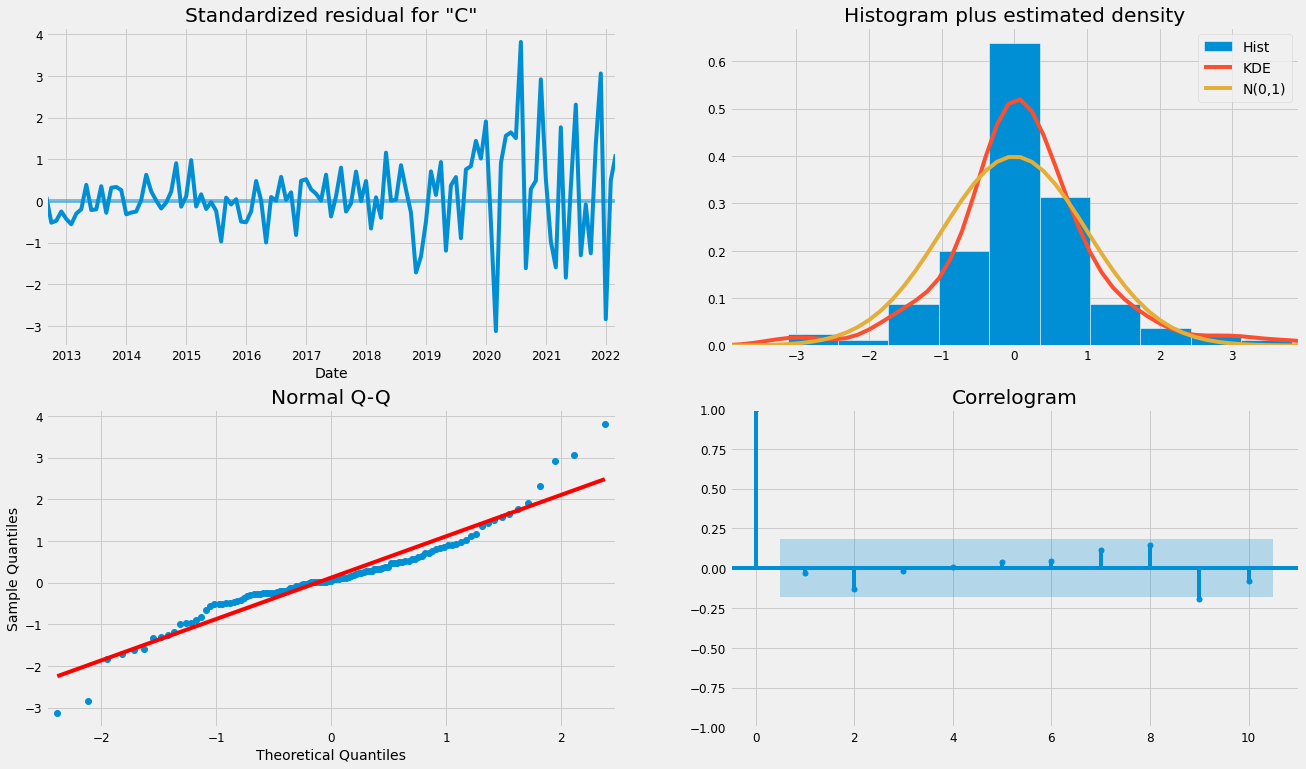

In [52]:
results.plot_diagnostics(figsize=(20, 12))
plt.show()

## Validating forecast

To help us understand the accuracy of our forecasts, we compare predicted Close to real close price of the time series, and we set forecasts to start at `2017-12-31` to the end of the data.

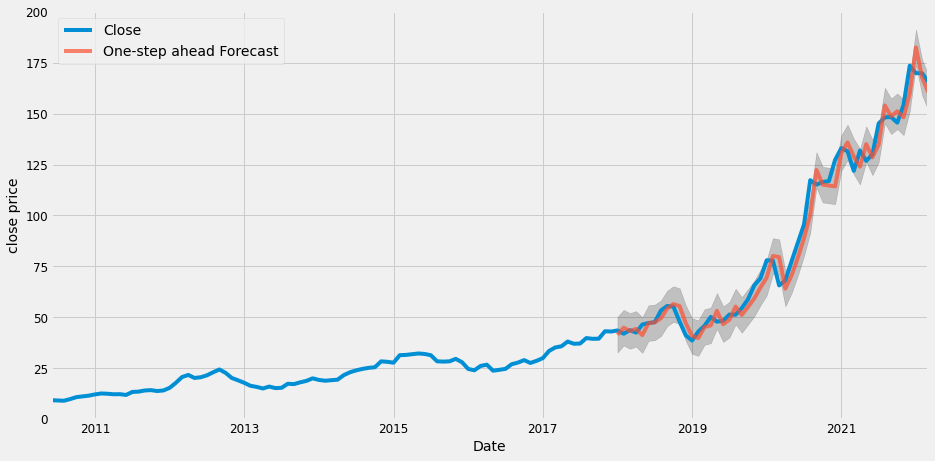

In [54]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False) # prediction start date
pred_ci = pred.conf_int()

ax = aapl['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [58]:
from sklearn.metrics import mean_squared_error
y_truth = aapl['2018-01-31':]
y_forecasted = pred.predicted_mean
mse = mean_squared_error(y_truth , y_forecasted)

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 40.6
The Root Mean Squared Error of our forecasts is 6.37


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily close price in the test set within portion... of the real close price.

In [57]:
actual=pd.DataFrame(aapl['2017-12-31':'2022-03-31'])

result = pd.concat([pred_ci, actual], axis=1).reindex(pred_ci.index)
display(result)

,lower Close,upper Close,Close
Date,,,
2018-01-31,32.626904,50.102030,43.501309
2018-02-28,36.120169,53.595295,41.909737
2018-03-31,34.494118,51.969244,43.624048
2018-04-30,35.519513,52.994639,42.458572
2018-05-31,32.479190,49.954316,46.384205
2018-06-30,38.383762,55.858888,47.155357
2018-07-31,38.702173,56.177298,47.577857
2018-08-31,40.774647,58.249772,53.336522
2018-09-30,45.572524,63.047650,55.518421


# The Roy Ratio

Since the stock prices differ greatly, we cannot just use the absolute value of the mean squared error to compare volatility between stocks. Thus, we use something we call the Roy ratio which is equal to the predicted value divided by the volatile range.

In [59]:
roy_ratio = ((pred_ci['upper Close']+pred_ci['lower Close'])/2 )/(pred_ci['upper Close']-pred_ci['lower Close'])
roy_ratio # predicted_mean/range of prediction=((upper+lower)/2)/upper-lower

Date
2018-01-31     2.367048
2018-02-28     2.566948
2018-03-31     2.473898
2018-04-30     2.532576
2018-05-31     2.358595
2018-06-30     2.696480
2018-07-31     2.714701
2018-08-31     2.833296
2018-09-30     3.107851
2018-10-31     3.230944
2018-11-30     3.173494
2018-12-31     2.689817
2019-01-31     2.331100
2019-02-28     2.275739
2019-03-31     2.585196
2019-04-30     2.630250
2019-05-31     3.040340
2019-06-30     2.665806
2019-07-31     2.789409
2019-08-31     3.160317
2019-09-30     2.925660
2019-10-31     3.152522
2019-11-30     3.387629
2019-12-31     3.696470
2020-01-31     3.975442
2020-02-29     4.582327
2020-03-31     4.551086
2020-04-30     3.665500
2020-05-31     4.035517
2020-06-30     4.527346
2020-07-31     5.083891
2020-08-31     5.738793
2020-09-30     6.999320
2020-10-31     6.588224
2020-11-30     6.561350
2020-12-31     6.539618
2021-01-31     7.478034
2021-02-28     7.774409
2021-03-31     7.380100
2021-04-30     7.091613
2021-05-31     7.724444
2021-06-30 